In [19]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder

In [20]:
print("The RQ for this quantitative analysis is: What travel motive do cyclists in the Netherlands cycle the longest duration for, and how does age influence this?")
print("The hypothesis being tested is: The relationship between travel motive and duration of a cycling trip differs significantly across age groups.")

The RQ for this quantitative analysis is: What travel motive do cyclists in the Netherlands cycle the longest duration for, and how does age influence this?
The hypothesis being tested is: The relationship between travel motive and duration of a cycling trip differs significantly across age groups.


In [21]:
# 1. CONFIGURATION
# Define all paths upfront
DATA_PATH = Path(
    r"..\csv tables\transport_per_motive.csv")
OUTPUT_FOLDER_CSV = Path(
    r"..\csv tables")
OUTPUT_FOLDER_VIS = Path(
    r"visualisations")

# Ensure output folders exist
for folder in [OUTPUT_FOLDER_CSV, OUTPUT_FOLDER_VIS]:
    folder.mkdir(parents=True, exist_ok=True)

In [22]:
# 2. DATA PROCESSING

def load_and_clean_data(file_path):
    """Load and clean the raw data"""
    data = pd.read_csv(file_path)

    # Rename columns to english
    data.rename(columns={ 
    'Geslacht': 'Gender',
    'Leeftijd': 'Age',
    'Vervoerwijzen': 'Mode of transport',
    'Reismotieven': 'Travel motives',
    'Marges': 'Margins',
    'Perioden': 'Year',
    'Ritten per persoon per dag (gemiddeld) (aantal)': 'Average trips per person per day',
    'Afgelegde afstand per rit (gemiddeld) (km)': 'Average travel distance per trip (km)',
    'Reisduur per rit (Minuten)': 'Average traveltime per tip (minutes)',
    }, inplace=True)

    # Remove unnecessary columns
    data.drop(columns=['Mode of transport'], inplace=True)
    data.drop(columns=['Year'], inplace=True)

    # Filter only 'Value' rows
    bicycle_data = data[data['Margins'] == 'Waarde'].copy()

    # Convert European number formats
    numeric_cols = [
       'Average trips per person per day',
       'Average travel distance per trip (km)',
        'Average traveltime per tip (minutes)',
    ]

    for col in numeric_cols:
        bicycle_data[col] = (
            bicycle_data[col]
            .astype(str)
            .str.replace(',', '.')
            .astype(float)
        )


    return bicycle_data

In [23]:
# One hot encoding for categorical variables
def one_hot_encode(data, column):
   encoder = OneHotEncoder(sparse_output=False, drop=['Totaal']) # Initialise the encoder

   one_hot_encoded = encoder.fit_transform(data[[column]]) # Fit the encder to the data and transform it

   one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(), index=data.index) # Create a DataFrame from the encoded data

   df_encoded = pd.concat([data, one_hot_df], axis=1).dropna() # Concatenate the original DataFrame with the one-hot encoded DataFrame

   df_encoded = df_encoded.drop(columns=[column]) # Drop the original column after encoding
   return df_encoded # Return the DataFrame with the one-hot encoded columns

bicycle_data = load_and_clean_data(DATA_PATH) 
travel_one_hot = one_hot_encode(bicycle_data, 'Travel motives') # One-hot encode the 'Travel motives' column


In [25]:
from itertools import product

travel_cols = [col for col in travel_one_hot.columns if col.startswith('Travel motives')]
age_cols = [col for col in travel_one_hot.columns if col.startswith('Age')]

# Create interaction columns
for t_col, a_col in product(travel_cols, age_cols):
    interaction_col = f'{t_col} * {a_col}'
    travel_one_hot[interaction_col] = pd.to_numeric(travel_one_hot[t_col], errors='coerce') * pd.to_numeric(travel_one_hot[a_col], errors='coerce')


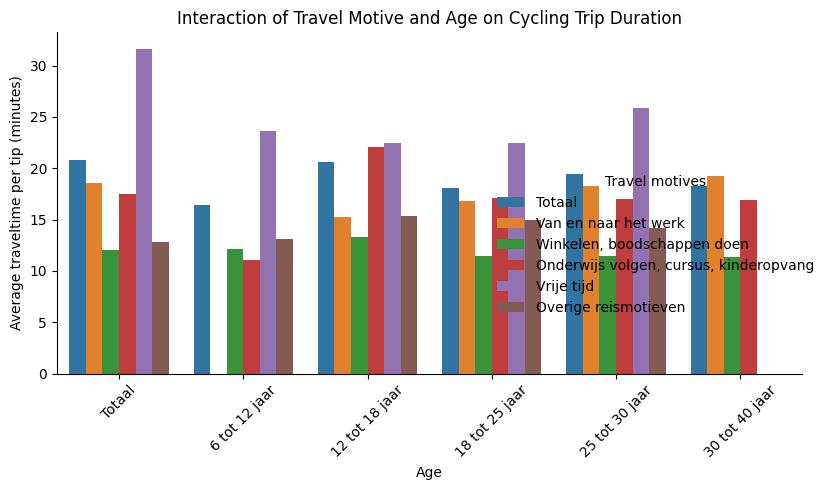

In [29]:
import seaborn as sns

sns.catplot(
    data=bicycle_data,
    kind="bar",
    x="Age",
    y="Average traveltime per tip (minutes)",
    hue="Travel motives",
)
plt.title("Interaction of Travel Motive and Age on Cycling Trip Duration")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [27]:
import statsmodels.api as sm

X = df[travel_cols + age_cols + [f'{t} * {a}' for t, a in product(travel_cols, age_cols)]]
X = sm.add_constant(X)
y = df['Average traveltime per tip (minutes)']

model = sm.OLS(y, X).fit()
print(model.summary())


KeyError: "['Travel motives_Onderwijs volgen, cursus, kinderopvang * Age', 'Travel motives_Overige reismotieven * Age', 'Travel motives_Van en naar het werk * Age', 'Travel motives_Vrije tijd * Age', 'Travel motives_Winkelen, boodschappen doen * Age'] not in index"

In [ ]:
# 3. LINEAR REGRESSION

def linear_regression(travel__one_hot):
    # Define predictors (all one-hot columns starting with 'Travel motives_')
    X = travel__one_hot.filter(like='Travel motives_')

    # Define response variable
    y = travel__one_hot['Average travel distance per trip (km)']


    # Add constant to the model (for intercept)
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X).fit()


    return model